# Netflix Recommender System

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re

## Understanding Data

In [76]:
df= pd.read_csv('netflix_titles.csv')

print(df.shape)
df.head()

(8807, 12)


show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

- Dataset terdiri dari 8807 baris dan 12 kolom.

## Select Movie Data

In [78]:
movies_df= df[df["type"] == "Movie"].reset_index(drop=True)

- Data difilter agar hanya mencakup jenis Movie, sesuai instruksi untuk menampilkan lima movie teratas.

In [79]:
print(movies_df.shape)
movies_df.head()

(6131, 12)


show_id   type                             title  \
0      s1  Movie              Dick Johnson Is Dead   
1      s7  Movie  My Little Pony: A New Generation   
2      s8  Movie                           Sankofa   
3     s10  Movie                      The Starling   
4     s13  Movie                      Je Suis Karl   

                        director  \
0                Kirsten Johnson   
1  Robert Cullen, José Luis Ucha   
2                   Haile Gerima   
3                 Theodore Melfi   
4            Christian Schwochow   

                                                cast  \
0                                                NaN   
1  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
2  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
3  Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
4  Luna Wedler, Jannis Niewöhner, Milan Peschel, ...   

                                             country          date_added  \
0                                      United States  September 25, 2021   
1                                                NaN  September 24, 2021   
2  United States, Ghana, Burkina Faso, United Kin...  September 24, 2021   
3                                      United States  September 24, 2021   
4                            Germany, Czech Republic  September 23, 2021   

   release_year rating duration  \
0          2020  PG-13   90 min   
1          2021     PG   91 min   
2          1993  TV-MA  125 min   
3          2021  PG-13  104 min   
4          2021  TV-MA  127 min   

                                          listed_in  \
0                                     Documentaries   
1                          Children & Family Movies   
2  Dramas, Independent Movies, International Movies   
3                                  Comedies, Dramas   
4                      Dramas, International Movies   

                                         description  
0  As her father nears the end of his life, filmm...  
1  Equestria's divided. But a bright-eyed hero be...  
2  On a photo shoot in Ghana, an American model s...  
3  A woman adjusting to life after a loss contend...  
4  After most of her family is murdered in a terr...

- Setelah proses filter, data tersisa sebanyak 6131 baris.

In [80]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6131 non-null   object
 1   type          6131 non-null   object
 2   title         6131 non-null   object
 3   director      5943 non-null   object
 4   cast          5656 non-null   object
 5   country       5691 non-null   object
 6   date_added    6131 non-null   object
 7   release_year  6131 non-null   int64 
 8   rating        6129 non-null   object
 9   duration      6128 non-null   object
 10  listed_in     6131 non-null   object
 11  description   6131 non-null   object
dtypes: int64(1), object(11)
memory usage: 574.9+ KB


- Terdapat Null Values pada kolom director, cast, country, rating, duration.
- Tipe data kolom date_added salah

## Preprocessing

### Drop Identifier

In [81]:
movies_df.nunique()

show_id         6131
type               1
title           6131
director        4354
cast            5445
country          651
date_added      1533
release_year      73
rating            17
duration         205
listed_in        278
description     6105
dtype: int64

In [82]:
movies_df= movies_df.drop(columns=['show_id'])

- Kolom show_id dibuang karena hanya berfungsi sebagai identifier dan tidak memiliki nilai tambah untuk keperluan pemodelan.
- Kolom title dipertahankan karena dianggap memiliki peran penting dalam sistem rekomendasi.

### Change Data Type

In [83]:
movies_df['date_added']= pd.to_datetime(movies_df['date_added'])

- Mengubah tipe data kolom date_added dari object menjadi datetime.

In [84]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   type          6131 non-null   object        
 1   title         6131 non-null   object        
 2   director      5943 non-null   object        
 3   cast          5656 non-null   object        
 4   country       5691 non-null   object        
 5   date_added    6131 non-null   datetime64[ns]
 6   release_year  6131 non-null   int64         
 7   rating        6129 non-null   object        
 8   duration      6128 non-null   object        
 9   listed_in     6131 non-null   object        
 10  description   6131 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 527.0+ KB


- Tipe kolom date_added sudah benar.

### Check Missing Values

In [85]:
print(movies_df.isnull().sum())

type              0
title             0
director        188
cast            475
country         440
date_added        0
release_year      0
rating            2
duration          3
listed_in         0
description       0
dtype: int64


In [86]:
print(movies_df.isnull().sum() / len(movies_df) * 100)

type            0.000000
title           0.000000
director        3.066384
cast            7.747513
country         7.176643
date_added      0.000000
release_year    0.000000
rating          0.032621
duration        0.048932
listed_in       0.000000
description     0.000000
dtype: float64


- Dataset memiliki jumlah NA values yang relatif sedikit, sehingga tidak diperlukan penghapusan kolom.

### Handling Missing Values

In [87]:
movies_df.head()

type                             title                       director  \
0  Movie              Dick Johnson Is Dead                Kirsten Johnson   
1  Movie  My Little Pony: A New Generation  Robert Cullen, José Luis Ucha   
2  Movie                           Sankofa                   Haile Gerima   
3  Movie                      The Starling                 Theodore Melfi   
4  Movie                      Je Suis Karl            Christian Schwochow   

                                                cast  \
0                                                NaN   
1  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
2  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
3  Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
4  Luna Wedler, Jannis Niewöhner, Milan Peschel, ...   

                                             country date_added  release_year  \
0                                      United States 2021-09-25          2020   
1                                                NaN 2021-09-24          2021   
2  United States, Ghana, Burkina Faso, United Kin... 2021-09-24          1993   
3                                      United States 2021-09-24          2021   
4                            Germany, Czech Republic 2021-09-23          2021   

  rating duration                                         listed_in  \
0  PG-13   90 min                                     Documentaries   
1     PG   91 min                          Children & Family Movies   
2  TV-MA  125 min  Dramas, Independent Movies, International Movies   
3  PG-13  104 min                                  Comedies, Dramas   
4  TV-MA  127 min                      Dramas, International Movies   

                                         description  
0  As her father nears the end of his life, filmm...  
1  Equestria's divided. But a bright-eyed hero be...  
2  On a photo shoot in Ghana, an American model s...  
3  A woman adjusting to life after a loss contend...  
4  After most of her family is murdered in a terr...

In [ ]:
movies_df["director"]= movies_df["director"].fillna("Unknown")
movies_df["cast"]= movies_df["cast"].fillna("Unknown")
movies_df["country"]= movies_df["country"].fillna("Unknown")
movies_df["rating"]= movies_df["rating"].fillna("Unknown")
movies_df["duration"]= movies_df["duration"].fillna("Unknown")

- NA values pada kolom director, cast, country, rating, dan duration diisi dengan nilai 'Unknown' untuk menjaga konsistensi data dan menghindari kehilangan informasi akibat penghapusan data.

In [89]:
print(movies_df.isnull().sum())

type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


- Setiap kolom sudah tidak ada NA values

### Check Duplicated Data

In [90]:
print(movies_df.duplicated().sum())

0


- Data duplikat tidak ditemukan, sehingga tidak diperlukan proses pembersihan untuk duplikasi.

## EDA

### Check Anomaly

In [91]:
pd.set_option('display.max_rows', None)

#### Type

In [92]:
movies_df['type'].value_counts()

type
Movie    6131
Name: count, dtype: int64

- Setelah difilter khusus untuk Movie, kolom type secara otomatis hanya berisi nilai Movie.

#### Title

In [93]:
movies_df['title'].value_counts()

title
Dick Johnson Is Dead                                                                                        1
Balto                                                                                                       1
Bangkok Traffic (Love) Story                                                                                1
Bangkok Hell                                                                                                1
Bang Rajan 2                                                                                                1
Band of Robbers                                                                                             1
Band Aid                                                                                                    1
Bana Masal Anlatma                                                                                          1
Balu Mahi                                                                                                   1
Balt

- Memuat seluruh judul film yang terdapat dalam dataset.

#### Director

In [94]:
movies_df['director'].value_counts()

director
Unknown                                                                                                                                                                                                             188
Rajiv Chilaka                                                                                                                                                                                                        19
Raúl Campos, Jan Suter                                                                                                                                                                                               18
Suhas Kadav                                                                                                                                                                                                          16
Marcus Raboy                                                                                                                   

- Memuat seluruh nama sutradara yang terdapat dalam dataset.
- Selain nilai Unknown, Rajiv Chilaka merupakan nama sutradara yang paling sering muncul.

#### Cast

In [95]:
movies_df['cast'].value_counts()

cast
Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     475
Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jigna Bhardwaj, Rajesh Kava, Mousam, Swapnil                                                                                                                                                                                                                                                                            

- Memuat seluruh nama pemeran yang terdapat dalam dataset.
- Selain nilai Unknown, Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jigna Bhardwaj, Rajesh Kava, Mousam, Swapnil merupakan nama pemeran yang sering muncul.

#### Country

In [96]:
movies_df['country'].value_counts()

country
United States                                                                                                                  2058
India                                                                                                                           893
Unknown                                                                                                                         440
United Kingdom                                                                                                                  206
Canada                                                                                                                          122
Spain                                                                                                                            97
Egypt                                                                                                                            92
Nigeria                                                             

- Memuat seluruh nama negara yang terdapat dalam dataset.
- United States merupakan nama negara yang sering muncul pada dataset.

##### Anomaly Discovery

In [97]:
def detect_country_anomalies(df):
  def is_anomaly(entry):
    if pd.isnull(entry):
      return False

    stripped= entry.strip()

    if stripped.startswith(',') or entry.startswith(' '):
      return True

    if stripped.endswith(','):
      return True

    countries= [part.strip() for part in entry.split(',') if part.strip()]
    for c in countries:
      if not c.istitle():
        return True

    return False

  return df[df['country'].apply(is_anomaly)]


In [98]:
anomaly_df= detect_country_anomalies(movies_df)

anomaly_df

type            title               director  \
237   Movie  Eyes of a Thief           Najwa Najjar   
788   Movie      The Present          Farah Nabulsi   
1443  Movie            Funan               Denis Do   
2975  Movie      City of Joy        Madeleine Gavin   
3827  Movie          Virunga  Orlando von Einsiedel   
4694  Movie    Hotel Pacific        Janusz Majewski   

                                                   cast  \
237   Khaled Abol El Naga, Souad Massi, Suhail Hadda...   
788   Saleh Bakri, Maryam Kanj, Maryam Kamiel Basha,...   
1443  Bérénice Bejo, Louis Garrel, Colette Kieffer, ...   
2975                                            Unknown   
3827                                            Unknown   
4694  Marek Kondrat, Roman Wilhelmi, Roman Skamene, ...   

                                     country date_added  release_year rating  \
237                        , France, Algeria 2021-07-30          2014  TV-14   
788                          United Kingdom, 2021-03-18          2020  TV-MA   
1443  France, Belgium, Luxembourg, Cambodia, 2020-07-18          2018  TV-14   
2975                          United States, 2018-09-07          2018  TV-MA   
3827                         United Kingdom, 2014-11-07          2014  TV-MA   
4694                                 Poland, 2019-10-01          1975  TV-MA   

     duration                                         listed_in  \
237   103 min  Dramas, Independent Movies, International Movies   
788    24 min                      Dramas, International Movies   
1443   87 min                      Dramas, International Movies   
2975   77 min                                     Documentaries   
3827  100 min               Documentaries, International Movies   
4694   96 min      Classic Movies, Dramas, International Movies   

                                            description  
237   After a decade in prison, a Palestinian man wi...  
788   Yusuf and his daughter set out to buy his wife...  
1443  Separated from their young son during the brut...  
2975  Women who've been sexually brutalized in war-t...  
3827  The Oscar-nominated true story of the rangers ...  
4694  A motivated teen strives to rise from dishwash...

- Terdapat nilai anomali pada kolom country, di mana beberapa nilai memiliki tanda koma di awal atau akhir.

#### Rating

In [99]:
movies_df['rating'].value_counts()

rating
TV-MA       2062
TV-14       1427
R            797
TV-PG        540
PG-13        490
PG           287
TV-Y7        139
TV-Y         131
TV-G         126
NR            75
G             41
TV-Y7-FV       5
NC-17          3
UR             3
Unknown        2
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

- Memuat seluruh kategori rating yang terdapat dalam dataset.
- TV-MA merupakan kategori rating yang paling sering muncul, yang berarti konten ditujukan untuk penonton dewasa dan tidak cocok untuk anak di bawah usia 17 tahun.

##### Anomaly Discovery

In [100]:
anomaly_values= ['74 min', '84 min', '66 min']
anomalies= movies_df[movies_df['rating'].isin(anomaly_values)]

anomalies

type                                 title    director        cast  \
3562  Movie                       Louis C.K. 2017  Louis C.K.  Louis C.K.   
3738  Movie                 Louis C.K.: Hilarious  Louis C.K.  Louis C.K.   
3747  Movie  Louis C.K.: Live at the Comedy Store  Louis C.K.  Louis C.K.   

            country date_added  release_year  rating duration listed_in  \
3562  United States 2017-04-04          2017  74 min  Unknown    Movies   
3738  United States 2016-09-16          2010  84 min  Unknown    Movies   
3747  United States 2016-08-15          2015  66 min  Unknown    Movies   

                                            description  
3562  Louis C.K. muses on religion, eternal love, gi...  
3738  Emmy-winning comedy writer Louis C.K. brings h...  
3747  The comic puts his trademark hilarious/thought...

- Anomali ditemukan pada kolom rating dimana valuenya merupakan durasi dari dataset.

#### Duration

In [101]:
movies_df['duration'].value_counts()

duration
90 min     152
94 min     146
93 min     146
97 min     146
91 min     144
95 min     137
96 min     130
92 min     129
102 min    122
98 min     120
99 min     118
101 min    116
88 min     116
103 min    114
106 min    111
100 min    108
89 min     106
104 min    104
86 min     103
87 min     101
105 min    101
107 min     98
110 min     97
108 min     87
116 min     80
112 min     74
85 min      73
109 min     69
113 min     69
111 min     68
84 min      67
83 min      65
118 min     65
119 min     63
81 min      62
117 min     61
115 min     61
120 min     56
114 min     56
121 min     54
82 min      52
124 min     52
127 min     48
78 min      45
122 min     45
123 min     44
126 min     44
80 min      43
133 min     42
128 min     41
130 min     40
135 min     39
137 min     38
132 min     37
125 min     36
75 min      35
79 min      35
131 min     34
72 min      33
63 min      32
129 min     32
74 min      31
61 min      31
76 min      31
77 min      30
73 min      30
6

- Memuat seluruh jenis durasi yang terdapat dalam dataset.
- 90 min merupakan durasi yang paling sering muncul.

#### Listed In

In [102]:
movies_df['listed_in'].value_counts()

listed_in
Dramas, International Movies                                        362
Documentaries                                                       359
Stand-Up Comedy                                                     334
Comedies, Dramas, International Movies                              274
Dramas, Independent Movies, International Movies                    252
Children & Family Movies                                            215
Children & Family Movies, Comedies                                  201
Documentaries, International Movies                                 186
Dramas, International Movies, Romantic Movies                       180
Comedies, International Movies                                      176
Comedies, International Movies, Romantic Movies                     152
Dramas                                                              138
Dramas, International Movies, Thrillers                             134
Action & Adventure, Dramas, International Movies      

- Memuat seluruh kategori genre yang terdapat dalam dataset.
- Dramas, International Movies merupakan genre yang paling sering muncul.

#### Date Added

In [103]:
movies_df['date_added'].value_counts()

date_added
2020-01-01    97
2019-11-01    75
2018-03-01    72
2019-12-31    67
2018-10-01    64
2018-11-01    55
2021-07-01    53
2019-10-01    51
2021-09-01    48
2018-01-01    47
2019-07-01    43
2021-06-02    42
2021-01-01    41
2018-04-01    38
2018-07-01    38
2020-04-01    34
2017-10-01    34
2021-08-01    33
2018-08-01    33
2019-01-01    33
2018-05-01    32
2021-05-01    30
2017-09-01    29
2020-07-05    28
2019-11-20    27
2019-09-01    26
2021-04-01    26
2018-08-02    25
2017-11-01    24
2021-07-22    24
2018-12-01    24
2017-05-01    24
2019-03-01    23
2020-10-01    22
2018-12-31    22
2019-08-01    22
2018-08-16    22
2019-04-01    21
2019-12-01    21
2017-06-01    21
2019-02-01    21
2020-11-01    21
2019-12-15    21
2021-08-27    20
2017-10-15    20
2017-03-10    20
2018-09-01    19
2019-02-15    19
2017-07-01    19
2017-04-01    19
2017-12-15    19
2021-04-23    18
2017-03-31    18
2020-06-01    18
2020-05-01    18
2018-03-15    18
2017-09-08    18
2017-12-01    17
202

- Memuat seluruh tanggal konten dimasukkan ke Netflix yang terdapat dalam dataset.
- Tanggal 2020-01-01 merupakan tanggal dengan jumlah konten terbanyak yang ditambahkan ke Netflix.

#### Release Year

In [104]:
movies_df['release_year'].value_counts()

release_year
2017    767
2018    767
2016    658
2019    633
2020    517
2015    398
2021    277
2014    264
2013    225
2012    173
2010    154
2011    145
2009    118
2008    113
2006     82
2007     74
2005     67
2004     55
2003     51
2002     44
2001     40
1997     34
2000     33
1998     32
1999     32
1993     24
1995     23
1996     21
1994     20
1992     20
1990     19
1982     17
1991     16
1988     16
1989     15
1981     12
1984     12
1980     11
1983     11
1986     11
1979     10
1973     10
1985      9
1976      9
1987      8
1978      7
1975      7
1977      6
1974      6
1971      5
1967      4
1960      4
1972      4
1943      3
1958      3
1944      3
1955      3
1945      3
1962      3
1968      3
1942      2
1965      2
1954      2
1964      2
1970      2
1956      2
1969      2
1959      1
1966      1
1961      1
1946      1
1963      1
1947      1
Name: count, dtype: int64

- Memuat seluruh tahun perilisan konten yang terdapat dalam dataset.
- Tahun 2017 merupakan tahun dengan jumlah konten perilisan terbanyak.

### Anomaly Handling

#### Country

In [105]:
def fix_country_anomalies(df):
  def clean_country(value):
    cleaned= value.strip().strip(',')
    countries= [c.strip().title() for c in cleaned.split(',') if c.strip()]
    return ', '.join(countries)

  df['country']= df['country'].apply(clean_country)
  return df

movies_df= fix_country_anomalies(movies_df)

- Menghapus spasi dan koma berlebih, serta menstandarkan format penulisan nama negara menjadi huruf kapital di awal setiap kata.

In [106]:
index= [237, 788, 1443, 2975, 3827, 4694]

movies_df.loc[index]

type            title               director  \
237   Movie  Eyes of a Thief           Najwa Najjar   
788   Movie      The Present          Farah Nabulsi   
1443  Movie            Funan               Denis Do   
2975  Movie      City of Joy        Madeleine Gavin   
3827  Movie          Virunga  Orlando von Einsiedel   
4694  Movie    Hotel Pacific        Janusz Majewski   

                                                   cast  \
237   Khaled Abol El Naga, Souad Massi, Suhail Hadda...   
788   Saleh Bakri, Maryam Kanj, Maryam Kamiel Basha,...   
1443  Bérénice Bejo, Louis Garrel, Colette Kieffer, ...   
2975                                            Unknown   
3827                                            Unknown   
4694  Marek Kondrat, Roman Wilhelmi, Roman Skamene, ...   

                                    country date_added  release_year rating  \
237                         France, Algeria 2021-07-30          2014  TV-14   
788                          United Kingdom 2021-03-18          2020  TV-MA   
1443  France, Belgium, Luxembourg, Cambodia 2020-07-18          2018  TV-14   
2975                          United States 2018-09-07          2018  TV-MA   
3827                         United Kingdom 2014-11-07          2014  TV-MA   
4694                                 Poland 2019-10-01          1975  TV-MA   

     duration                                         listed_in  \
237   103 min  Dramas, Independent Movies, International Movies   
788    24 min                      Dramas, International Movies   
1443   87 min                      Dramas, International Movies   
2975   77 min                                     Documentaries   
3827  100 min               Documentaries, International Movies   
4694   96 min      Classic Movies, Dramas, International Movies   

                                            description  
237   After a decade in prison, a Palestinian man wi...  
788   Yusuf and his daughter set out to buy his wife...  
1443  Separated from their young son during the brut...  
2975  Women who've been sexually brutalized in war-t...  
3827  The Oscar-nominated true story of the rangers ...  
4694  A motivated teen strives to rise from dishwash...

- Format penulisan pada kolom country sudah benar.

#### Rating

In [107]:
anomaly_values= ['74 min', '84 min', '66 min']

mask= movies_df['rating'].isin(anomaly_values)

movies_df.loc[mask, ['rating', 'duration']]= movies_df.loc[mask, ['duration', 'rating']].values

movies_df.loc[mask]

type                                 title    director        cast  \
3562  Movie                       Louis C.K. 2017  Louis C.K.  Louis C.K.   
3738  Movie                 Louis C.K.: Hilarious  Louis C.K.  Louis C.K.   
3747  Movie  Louis C.K.: Live at the Comedy Store  Louis C.K.  Louis C.K.   

            country date_added  release_year   rating duration listed_in  \
3562  United States 2017-04-04          2017  Unknown   74 min    Movies   
3738  United States 2016-09-16          2010  Unknown   84 min    Movies   
3747  United States 2016-08-15          2015  Unknown   66 min    Movies   

                                            description  
3562  Louis C.K. muses on religion, eternal love, gi...  
3738  Emmy-winning comedy writer Louis C.K. brings h...  
3747  The comic puts his trademark hilarious/thought...

- Menukar value kolom rating dan duration.

### Univariate

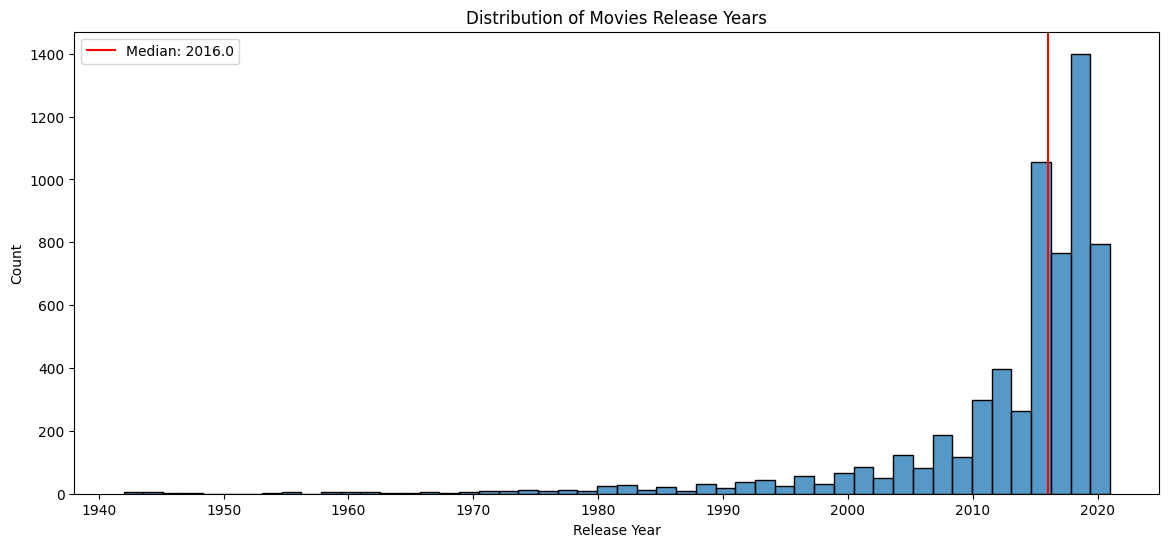

In [108]:
plt.figure(figsize= (14, 6))
sns.histplot(movies_df['release_year'], bins= 50)
plt.title('Distribution of Movies Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.axvline(x= movies_df['release_year'].median(), color='red', label=f'Median: {movies_df["release_year"].median()}')
plt.legend()
plt.show()

- Dari plot ini, kita bisa dapatkan bahwa distribusi dari data tidak merata dan condrong ke kanan (right skewed). Sebagian besar film dirilis setelah tahun 2000, dengan peningkatan yang sangat tajam dari sekitar tahun 2010 hingga 2020. Ini menunjukkan bahwa produksi film meningkat drastis dalam dua dekade terakhir.
- Garis merah menandai median, ini berarti setengah dari semua film dirilis setelah tahun 2016, dan setengahnya sebelum. Ini mendukung temuan bahwa sebagian besar film berasal dari era modern.
- Hampir tidak ada film yang dirilis sebelum 1980 berdasarkan histogram ini. Ini bisa disebabkan oleh kurangnya data historis yang terdokumentasi secara digital.

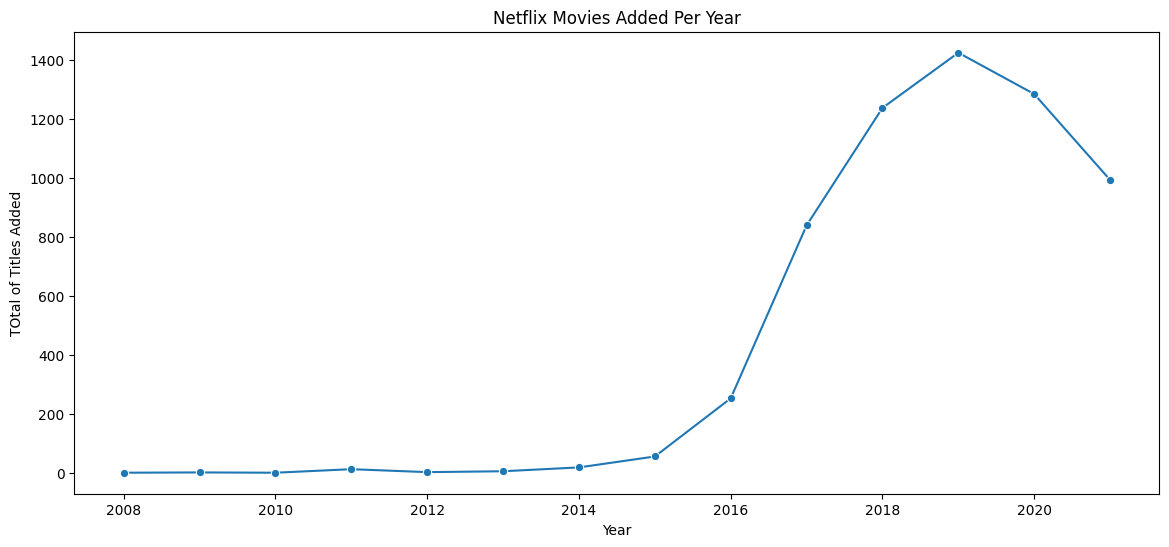

In [109]:
movies_df['year_added']= pd.to_datetime(movies_df['date_added']).dt.year

plt.figure(figsize=(14, 6))
yearly_trend= movies_df['year_added'].value_counts().sort_index()
sns.lineplot(x= yearly_trend.index, y= yearly_trend.values, marker='o')
plt.title('Netflix Movies Added Per Year')
plt.xlabel('Year')
plt.ylabel('TOtal of Titles Added')
plt.show()

- Dari plot ini, kita bisa ketahui bahwa selama 7 tahun pertama, jumlah film yang ditambahkan sangat sedikit, di bawah 50 judul per tahun. Ini menandakan awal mulanya Netflix mulai fokus pada streaming sekitar 2007-2010, namun awalnya kontennya terbatas.
- Terjadinya lonjakan drastis mulai tahun 2016, naik dari sekitar 250 film hingga mencapai puncak tertinggi pada 2019 dengan lebih dari 1400 judul. Ini karena Netflix ingin memperluas pasar global.
- Namun terjadi penurunan jumlah film yang ditambahkan setelah 2019. Yang kemungkinan terjadi akibat Pandemi COVID-19 yang membatasi produksi film dan akuisisi konten atau munculnya banyak kompetitor streaming (Disney+, HBO Max) yang membuat persaingan konten lebih ketat.

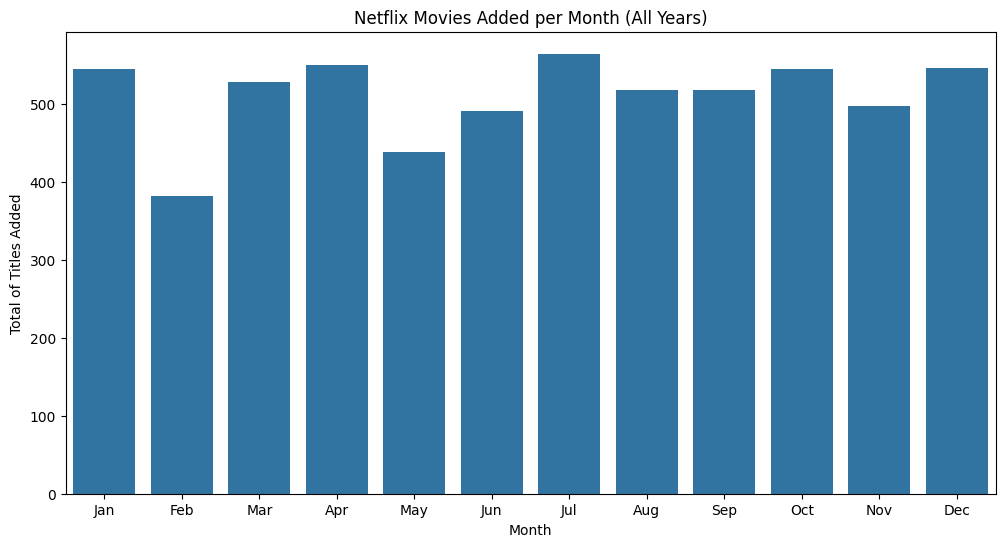

In [110]:
movies_df['month_added'] = pd.to_datetime(movies_df['date_added']).dt.month

plt.figure(figsize= (12, 6))
monthly_trend= movies_df['month_added'].value_counts().sort_index()
sns.barplot(x= monthly_trend.index, y= monthly_trend.values)
plt.title('Netflix Movies Added per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Total of Titles Added')
plt.xticks(ticks= range(12), labels= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

- Plot ini menunjukkan bahwa, jumlah film yang ditambahkan per bulan relatif stabil di atas 500 judul untuk sebagian besar bulan. 
- Tidak ada perbedaan ekstrem antarmusim, yang menunjukkan bahwa Netflix cenderung menambah konten secara konsisten sepanjang tahun.

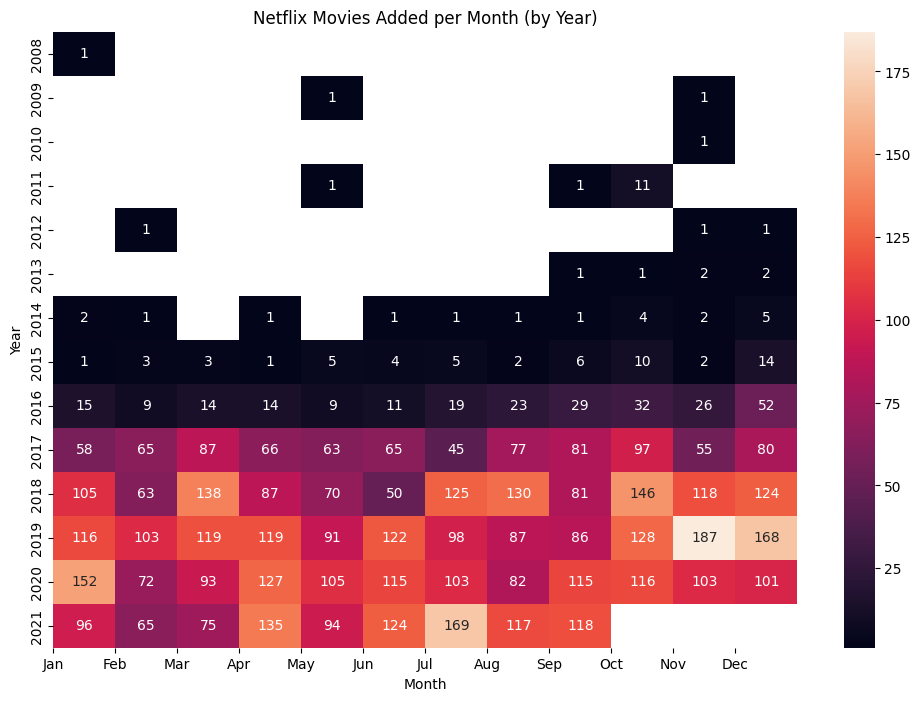

In [111]:
monthly_year= movies_df.groupby(['year_added', 'month_added']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(monthly_year, annot=True, fmt='g')
plt.title('Netflix Movies Added per Month (by Year)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.xticks(ticks= range(12), labels= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

- Dari plot ini bisa kita dapatkan bahwa, Netflix mulai agresif menambahkan film sejak 2016, dengan puncak pada 2018-2019. Dimana sebelum 2015, penambahan film sangat sedikit dan sporadis. Namun mulai 2016, kita melihat peningkatan yang stabil, dan ledakan besar terjadi di 2018 dan 2019.
- 2019 adalah tahun paling aktif dimana November dan Desember mencatat angka tertinggi, masing-masing 187 dan 168 film.
- 2021 menunjukkan puncak besar di Juli. Data terakhir kali dicatat pada bulan Oktober.

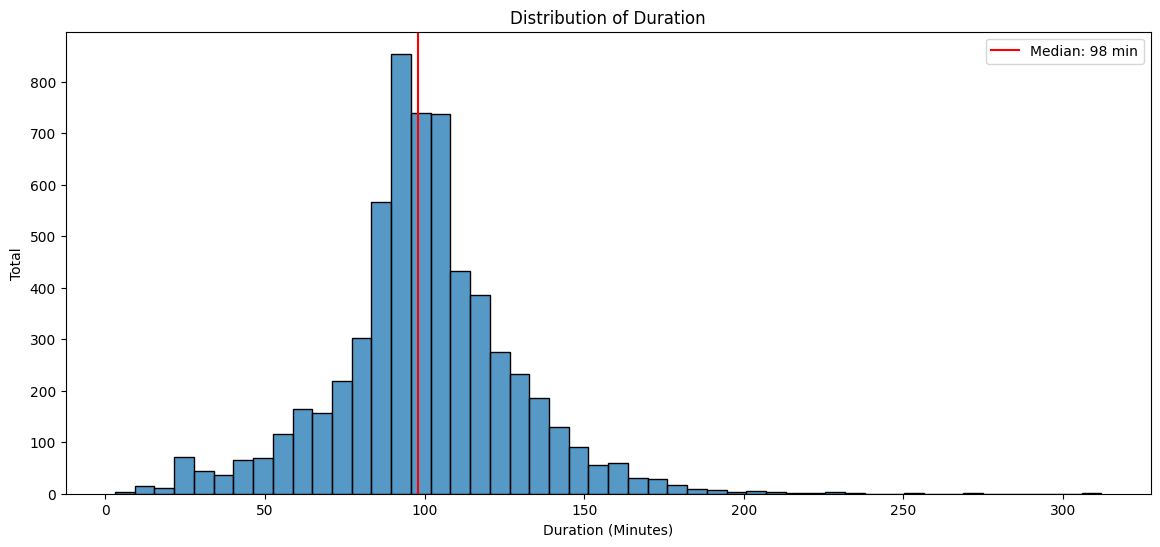

In [112]:
movies_df['duration_min']= movies_df['duration'].str.extract('(\d+)').astype(float)

plt.figure(figsize=(14, 6))
sns.histplot(movies_df['duration_min'], bins= 50)
plt.axvline(movies_df['duration_min'].median(), color='red', label=f'Median: {movies_df["duration_min"].median():.0f} min')
plt.title('Distribution of Duration')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Total')
plt.legend()
plt.show()

- Plot distribusi dari durasi film yang ada pada data Netflix ini menunjukkan bahwa distribusinya positif dan sedikit skewed ke kanan. Yang berarti bahwa sebagian besar film berdurasi pendek–menengah (sekitar 80-120 menit). Ada beberapa film berdurasi sangat panjang (hingga 300+ menit), tapi jumlahnya sangat kecil (outliers).
- Titik tertinggi pada sekitar 90–100 menit. Ini menunjukkan bahwa durasi film paling umum di Netflix berkisar di rentang ini.
- Mediannya berkisaran sekitar 98an menit yang berarti setengah dari film berdurasi ≤ 98 menit, dan separuh sisanya lebih dari itu
- Ada film yang sangat panjang (>200 menit), meskipun sangat jarang. Bisa jadi dokumenter panjang, miniseri yang dikemas sebagai satu file, atau film epik.

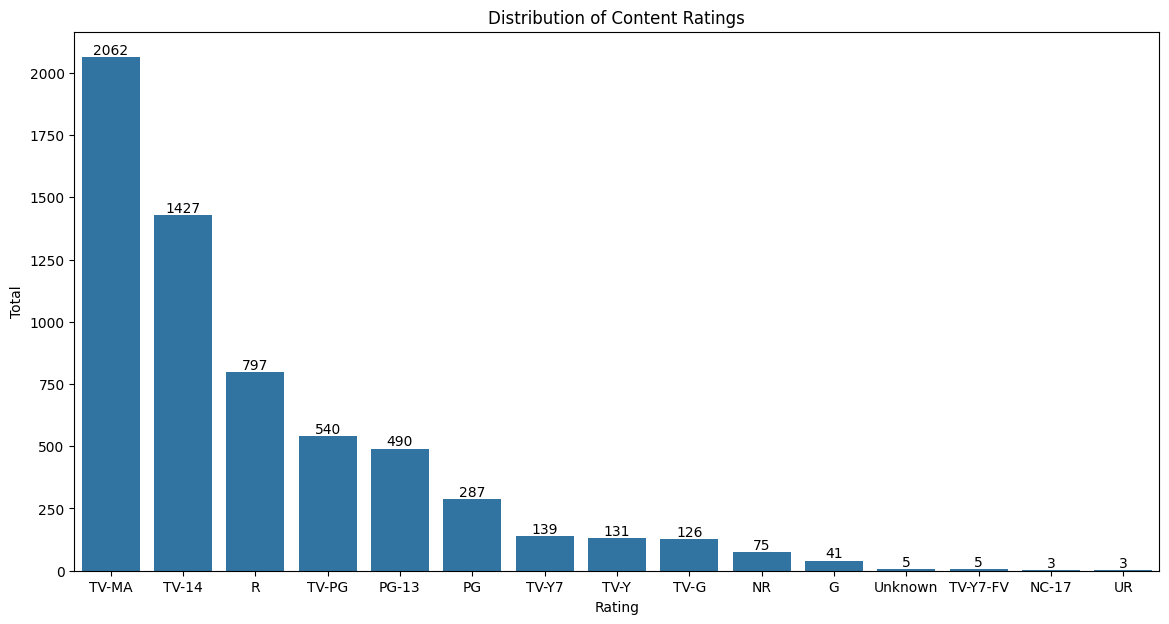

In [113]:
plt.figure(figsize= (14, 7))
rating_order= movies_df['rating'].value_counts().index
ax= sns.countplot(x= 'rating', data= movies_df, order= rating_order)
plt.title('Distribution of Content Ratings')
plt.xlabel('Rating')
plt.ylabel('Total')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

- Graf ini memperlihatkan mengenai konten ratings yang ada pada dataset Netflix, dimana ini menunjukkan bahwa TV-Y, TV-G, G, dan TV-Y7 masing-masing < 150 judul. Ini menandakan bahwa konten anak-anak bukan fokus utama Netflix, meski tetap tersedia.
- Beberapa konten tidak memiliki rating (NR, Unknown, UR) atau memiliki rating langka (NC-17, TV-Y7-FV) totalnya sangat kecil. Ini bisa berasal dari film luar negeri, dokumenter niche, atau konten lawas yang tidak diklasifikasikan.

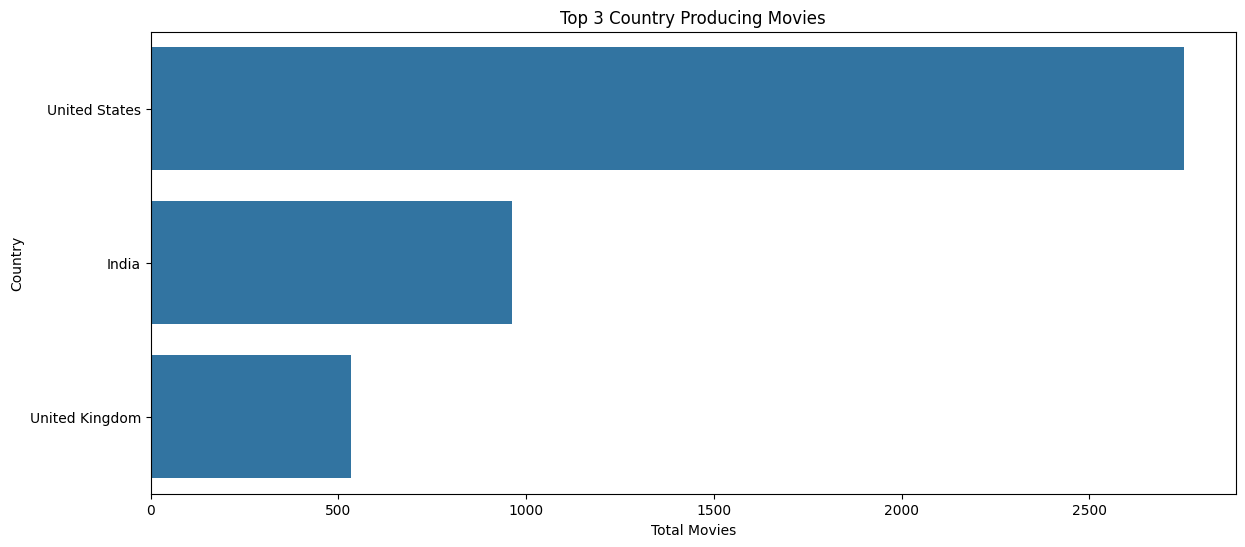

In [114]:
countries= movies_df['country'].str.split(', ').explode()
top_countries= countries.value_counts().head(3)

plt.figure(figsize= (14, 6))
sns.barplot(x= top_countries.values, y= top_countries.index)
plt.title('Top 3 Country Producing Movies')
plt.xlabel('Total Movies')
plt.ylabel('Country')
plt.show()

- Grafik ini menunjukkan bahwa United States adalah negara yang paling banyak memproduksi film, dengan jumlah sekitar 2700+ film. 
- India berada di posisi kedua, dengan total film yang diproduksi sekitar 950-an.
- United Kingdom menempati posisi ketiga dengan total produksi sekitar 500-an film.
- Selisih yang besar terlihat antara posisi pertama dan kedua. Produksi film di Amerika Serikat jauh lebih tinggi daripada dua negara lainnya.

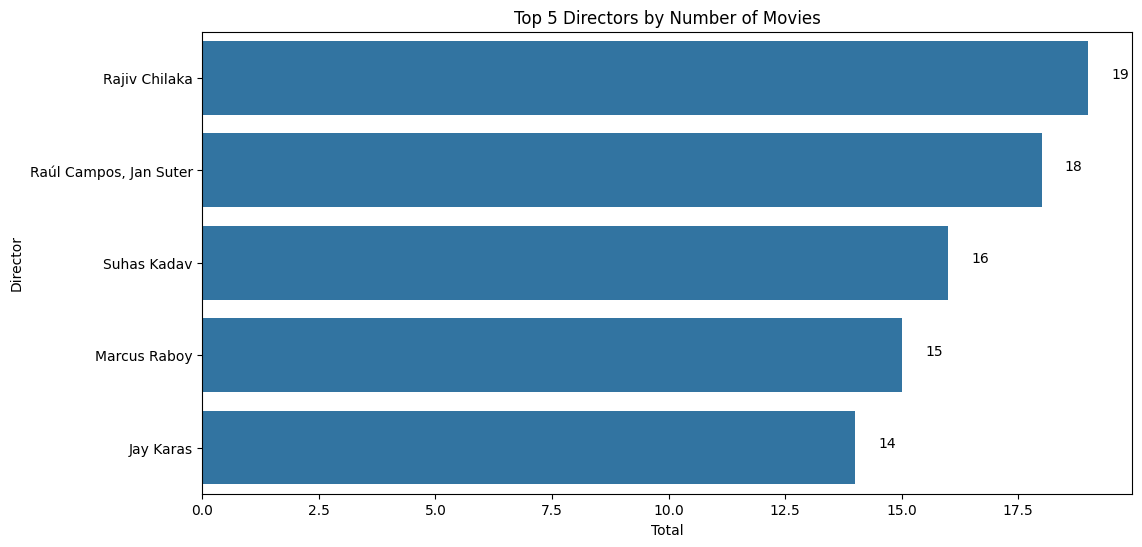

In [115]:
top_directors= movies_df[movies_df['director'] != 'Unknown']['director'].value_counts().head(5)

plt.figure(figsize= (12, 6))
sns.barplot(x= top_directors.values, y= top_directors.index)
plt.title('Top 5 Directors by Number of Movies')
plt.xlabel('Total')
plt.ylabel('Director')

for i, v in enumerate(top_directors.values):
  plt.text(v + 0.5, i, str(v), color= 'black')
plt.show()

- Grafik ini menginformasikan tentang siapa saja sutradara yang paling produktif berdasarkan jumlah film yang telah mereka arahkan. 
- Rajiv Chilaka adalah sutradara paling produktif dalam dataset ini dengan 19 film.
- Perbedaan antar posisi cukup kecil, menunjukkan tingkat produktivitas yang relatif seimbang antar sutradara dalam daftar ini.



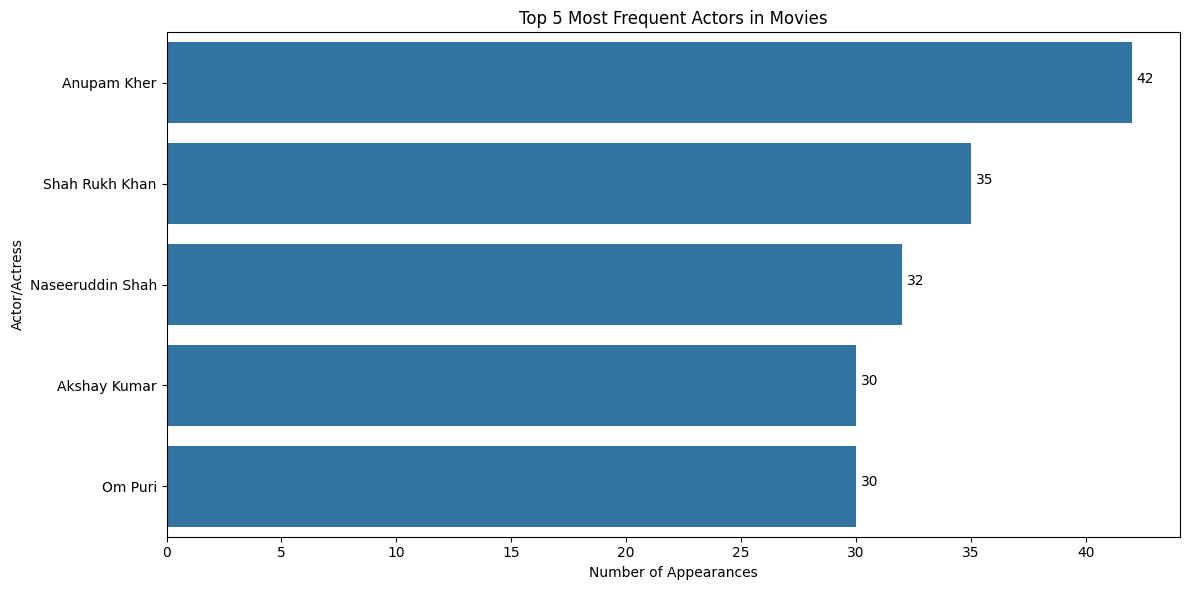

In [116]:
all_cast= []
for cast_list in movies_df['cast'].dropna().str.split(', '):
  cleaned_cast= [actor.strip() for actor in cast_list if actor.strip() != 'Unknown']
  all_cast.extend(cleaned_cast)

cast_counts= Counter(all_cast).most_common(5)
top_cast= pd.DataFrame(cast_counts, columns=['Actor', 'Count'])

plt.figure(figsize= (12, 6))
ax= sns.barplot(x= 'Count', y= 'Actor', data= top_cast)
plt.title('Top 5 Most Frequent Actors in Movies')
plt.xlabel('Number of Appearances')
plt.ylabel('Actor/Actress')

for i, v in enumerate(top_cast['Count']):
  ax.text(v + 0.2, i, str(v), color= 'black')

plt.tight_layout()
plt.show()

- Anupam Kher adalah aktor dengan penampilan terbanyak (42 kali), menunjukkan keterlibatannya yang sangat tinggi dalam industri film.
- Dominasi aktor India terlihat jelas, semua nama berasal dari industri film India (kemungkinan besar Bollywood).



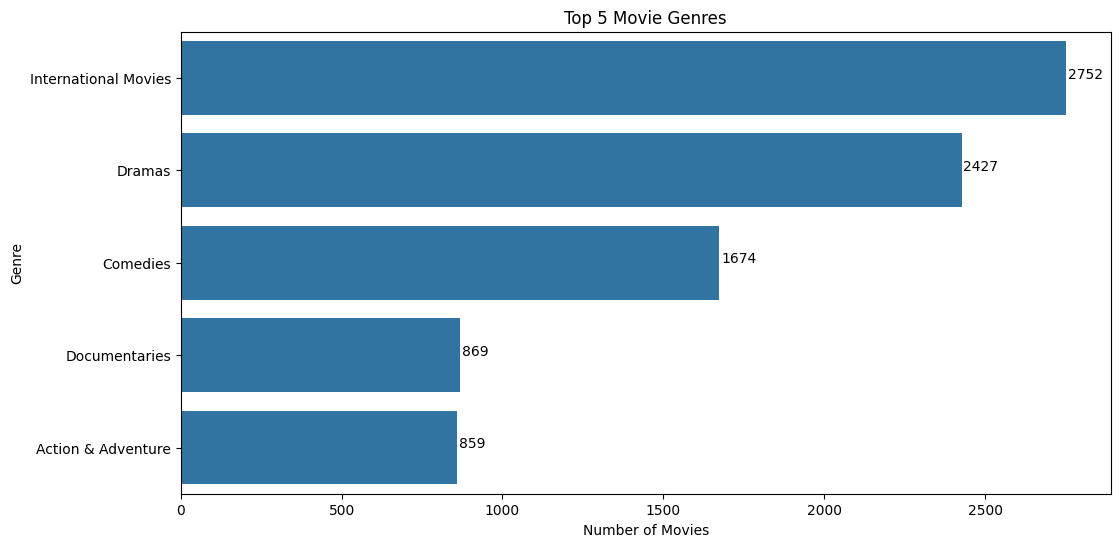

In [117]:
genres_list= movies_df['listed_in'].str.split(', ').explode()
top_genres= genres_list.value_counts().head(5)

plt.figure(figsize= (12, 6))
sns.barplot(x= top_genres.values, y= top_genres.index)
plt.title('Top 5 Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

for i, v in enumerate(top_genres.values):
  plt.text(v + 5, i, str(v), color='black')
plt.show()

- International Movies menjadi genre paling dominan (2752 film), menunjukkan bahwa banyak film dalam dataset ini berasal dari atau ditujukan untuk pasar internasional. Ini bisa mencakup berbagai bahasa dan negara asal.
- Dramas berada di posisi kedua (2427 film), menandakan bahwa drama tetap menjadi genre populer, biasanya karena fleksibilitas narasi dan kedalaman emosional.
- Comedies berada di posisi ketiga (1674 film), menunjukkan selera hiburan ringan tetap tinggi di kalangan penonton.


## Build Recommender System

In [118]:
movies_df= movies_df.drop(columns=['year_added', 'month_added', 'duration_min'])

- Drop kolom year_added, month_added, dan duration_min karena itu hanya dipakai saat EDA.

### Make Soup Feature

In [119]:
movies_df.head()

type                             title                       director  \
0  Movie              Dick Johnson Is Dead                Kirsten Johnson   
1  Movie  My Little Pony: A New Generation  Robert Cullen, José Luis Ucha   
2  Movie                           Sankofa                   Haile Gerima   
3  Movie                      The Starling                 Theodore Melfi   
4  Movie                      Je Suis Karl            Christian Schwochow   

                                                cast  \
0                                            Unknown   
1  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
2  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
3  Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
4  Luna Wedler, Jannis Niewöhner, Milan Peschel, ...   

                                             country date_added  release_year  \
0                                      United States 2021-09-25          2020   
1                                            Unknown 2021-09-24          2021   
2  United States, Ghana, Burkina Faso, United Kin... 2021-09-24          1993   
3                                      United States 2021-09-24          2021   
4                            Germany, Czech Republic 2021-09-23          2021   

  rating duration                                         listed_in  \
0  PG-13   90 min                                     Documentaries   
1     PG   91 min                          Children & Family Movies   
2  TV-MA  125 min  Dramas, Independent Movies, International Movies   
3  PG-13  104 min                                  Comedies, Dramas   
4  TV-MA  127 min                      Dramas, International Movies   

                                         description  
0  As her father nears the end of his life, filmm...  
1  Equestria's divided. But a bright-eyed hero be...  
2  On a photo shoot in Ghana, an American model s...  
3  A woman adjusting to life after a loss contend...  
4  After most of her family is murdered in a terr...

In [120]:
def clean_text(text):
  if pd.isna(text):
    return ""
  text= re.sub(r'[^\w\s]', '', str(text).lower())  
  return text

- Fungsi ini untuk mengubah karakter non alfabetik ([^\w\s]), ubah jadi huruf kecil (lower()), Hilangkan NaN (mengembalikan string kosong jika nilai kosong).

In [121]:
def create_soup(row):
  title= ' '.join([clean_text(row['title'])] * 2)

  genres= ' '.join([clean_text(g) for g in str(row['listed_in']).split(', ')]) * 3 

  director= clean_text(row['director']) * 2
  cast= ' '.join([clean_text(a) for a in str(row['cast']).split(', ') if a.strip().lower() != 'unknown'])
  description= clean_text(row['description'])
  country= clean_text(row['country'])
  rating= clean_text(row['rating'])

  return f"{title} {genres} {director} {cast} {country} {rating} {description}"

movies_df['soup']= movies_df.apply(create_soup, axis=1)

- Fungsi ini untuk gabungkan informasi informasi utama dari tiap baris ke dalam satu string panjang (soup). 
- Dimana Judul diulang 2× agar diberi bobot lebih dalam perhitungan kemiripan.
- Genre dipecah berdasarkan koma, dibersihkan, lalu diulang 3× karena genre adalah fitur penting.
- Nama sutradara juga diberi bobot tambahan.
- Daftar aktor (yang bukan 'unknown') dibersihkan dan digabung.
- Deskripsi, negara, dan rating dibersihkan.

In [122]:
print(movies_df['soup'].iloc[0])

dick johnson is dead dick johnson is dead documentariesdocumentariesdocumentaries kirsten johnsonkirsten johnson  united states pg13 as her father nears the end of his life filmmaker kirsten johnson stages his death in inventive and comical ways to help them both face the inevitable


### TF-IDF

In [123]:
tfidf= TfidfVectorizer(stop_words= 'english', ngram_range=(1, 2), min_df=2, max_df=0.8)
tfidf_matrix= tfidf.fit_transform(movies_df['soup'])

- TfidfVectorizer ini mengubah teks 'soup' menjadi matriks numerik berdasarkan frekuensi kata dengan skema TF-IDF. Dimana hasil akhir dari tfidf_matrix adalah representasi vektor dari seluruh film, berdasarkan kombinasi fitur-fitur teks yang telah dibersihkan dan digabungkan.

### Cosine similarity

In [124]:
cosine_sim= linear_kernel(tfidf_matrix, tfidf_matrix)

- Linear_kernel digunakan untuk menghitung cosine similarity antar film berdasarkan representasi TF-IDF-nya. Nilai cosine similarity berkisar antara 0 (tidak mirip) hingga 1 (identik). Hasilnya matriks 2D cosine_sim yang berisi kemiripan antara setiap pasangan film.

### Save to Pickle

In [125]:
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [127]:
pickle.dump(movies_df, open('movies_df.pkl', 'wb'))

- Data dan model disimpan dalam format Pickle agar bisa digunakan kembali tanpa harus melatih ulang

### Build Model

In [128]:
def get_recommendations(title, movies_df, cosine_sim, top_n=5):
  idx= movies_df[movies_df['title'].str.lower() == title.lower()].index[0]

  sim_scores= list(enumerate(cosine_sim[idx]))
  sim_scores= sorted(sim_scores, key= lambda x: x[1], reverse= True)

  movie_indices= [i[0] for i in sim_scores[1:top_n+1]]

  recommendations= movies_df.iloc[movie_indices][['title', 'listed_in', 'director', 'cast', 'country', 'rating', 'description']].copy()
  recommendations['similarity']= [round(sim_scores[i][1], 6) for i in range(1, top_n+1)]

  print("="*80)
  print(f"🎬 DETAIL FILM: {movies_df.iloc[idx]['title'].upper()}")
  print("="*80)
  print(f"Genre: {movies_df.iloc[idx]['listed_in']}")
  print(f"Director: {movies_df.iloc[idx]['director']}")
  print(f"Cast: {movies_df.iloc[idx]['cast']}")
  print(f"Country: {movies_df.iloc[idx]['country']}")
  print(f"Rating: {movies_df.iloc[idx]['rating']}")
  print(f"Description: {movies_df.iloc[idx]['description']}\n\n")

  print(f"🍿 REKOMENDASI TOP {top_n}")
  print("="*80)
  for i, row in recommendations.iterrows():
    print(f"\n> {row['title']} (Similarity: {row['similarity']})")
    print("-"*60)
    print(f"Genre: {row['listed_in']}")
    print(f"Director: {row['director']}")
    print(f"Cast: {row['cast']}")
    print(f"Country: {row['country']}")
    print(f"Rating: {row['rating']}")
    print(f"Description: {row['description']}")

  return recommendations

- Function ini digunakan untuk membangun content based recommender system yang mengembalikan 5 recommendations yang berisi daftar film paling mirip. Dan juga menyertakan informasi tambahan: genre, sutradara, pemeran, negara, rating, dan deskripsi. 
- Sistem akan menerima input berupa judul film. Kemudian menghitung kesamaan konten menggunakan cosine similarity, mengambil dan menampilkan film dengan konten paling mirip.

## Evaluate Model

### Evaluasi Recommender System untuk God's Not Dead

In [129]:
hasil= get_recommendations("God's Not Dead", movies_df, cosine_sim, top_n=5)

🎬 DETAIL FILM: GOD'S NOT DEAD
Genre: Dramas, Faith & Spirituality
Director: Harold Cronk
Cast: Kevin Sorbo, Shane Harper, David A.R. White, Dean Cain, Benjamin A. Onyango, Paul Kwo, Hadeel Sittu, Trisha LaFache, Cory Oliver, Willie Robertson, Korie Robertson
Country: United States
Rating: PG
Description: A spiritual college student clashes with an atheistic professor who insists that students will only pass his class by admitting that God is dead.


🍿 REKOMENDASI TOP 5

> God's Not Dead: A Light in Darkness (Similarity: 0.533755)
------------------------------------------------------------
Genre: Dramas, Faith & Spirituality
Director: Michael Mason
Cast: David A.R. White, John Corbett, Shane Harper, Ted McGinley, Jennifer Taylor, Benjamin A. Onyango, Tatum O'Neal, Cissy Houston
Country: United States
Rating: PG
Description: After a fire breaks out at his church, a pastor faces a legal battle against university leaders who wish to push the congregation off the campus.

> Freshman Year (

Film God's Not Dead adalah drama keagamaan yang berfokus pada konflik antara iman dan ateisme di lingkungan universitas. Tema sentralnya adalah pembelaan iman Kristen di tengah tekanan sosial dan akademis.

- Dimana yang pertama yaitu God's Not Dead: A Light in Darkness yang memiliki similarity score 0.533755 yang merupakan sekuel langsung dari film utama. Genre dan tema sangat mirip dan pemeran juga sebagian sama (David A.R. White, Benjamin A. Onyango). Sehingga cocok dijadikan rekomendasi utama. Ini menunjukkan bahwa sistem mampu mengenali kelanjutan cerita/franchise.
- Yang kedua yaitu Freshman Year dengan similarity score 0.345237 dimana film ini memiliki tema spiritual dan pendidikan juga muncul. Sehingga terdapat kesamaan suasana dan genre.

Semua film yang direkomendasikan masuk dalam genre Dramas, Faith & Spirituality, dan menampilkan tokoh yang bergulat dengan iman, tantangan hidup, dan hubungan spiritual. Misalnya:
- Freshman Year: tantangan iman di kampus.
- An Interview with God: dialog spiritual eksistensial.
- The Reliant: nilai-nilai keluarga dan iman di tengah krisis.
- Like Arrows: kehidupan keluarga berpusat pada iman.

Sistem tampaknya mampu menangkap inti tematik film utama, yaitu perjuangan mempertahankan iman dalam dunia modern yang skeptis.

Kekurangan : 
- Similarity Score Relatif Rendah Setelah Film Pertama : Dimana hanya rekomendasi pertama yang memiliki similarity di atas 0.5. Rekomendasi lainnya berkisar antara 0.3-0.34, menandakan bahwa sistem mulai kurang yakin akan kesamaan film selanjutnya.
- Meskipun semua film bernuansa rohani, tidak semua memiliki latar pendidikan/universitas seperti God's Not Dead, yang bisa jadi penting untuk menjaga konteks tematik.

Kesimpulannya sistem ini bekerja cukup baik untuk film bertema agama seperti God's Not Dead. Dimana rekomendasi pertama adalah pilihan paling relevan dan kuat karena merupakan bagian dari waralaba. Film lain tetap mempertahankan genre, tema moral, dan nilai-nilai spiritual, meski konteks cerita sedikit bergeser. Sistem ini cocok untuk penonton yang mencari film inspiratif berbasis iman Kristen.

### Evaluasi Recommender System untuk Teenage Mutant Ninja Turtles II: The Secret of the Ooze

In [130]:
hasil= get_recommendations("Teenage Mutant Ninja Turtles II: The Secret of the Ooze", movies_df, cosine_sim, top_n=5)

🎬 DETAIL FILM: TEENAGE MUTANT NINJA TURTLES II: THE SECRET OF THE OOZE
Genre: Children & Family Movies, Comedies
Director: Michael Pressman
Cast: Paige Turco, David Warner, Mark Caso, Michelan Sisti, Leif Tilden, Kenn Scott, Kevin Clash, Ernie Reyes Jr., François Chau, Kevin Nash
Country: United States, Hong Kong
Rating: PG
Description: The evil Shredder decides that ooze is what gives the ninja turtles their power, so he obtains some of the toxic junk and creates dangerous mutants.


🍿 REKOMENDASI TOP 5

> Teenage Mutant Ninja Turtles: The Movie (Similarity: 0.586005)
------------------------------------------------------------
Genre: Action & Adventure, Comedies
Director: Steve Barron
Cast: Judith Hoag, Elias Koteas, Josh Pais, Michelan Sisti, Leif Tilden, David Forman, Michael Turney, Jay Patterson, Raymond Serra, James Saito, Kevin Clash
Country: Unknown
Rating: PG
Description: After exposure to a strange, glowing ooze, four mutant turtles train as ninjas in the sewers and fight cr

Film TEENAGE MUTANT NINJA TURTLES II: THE SECRET OF THE OOZE adalah film keluarga-komedi aksi yang menampilkan karakter ikonik Teenage Mutant Ninja Turtles dalam petualangan melawan mutan jahat buatan musuh lama mereka, Shredder. Genre-nya ringan, penuh aksi dan komedi, cocok untuk anak-anak dan keluarga.

Dua rekomendasi teratas adalah:
- Teenage Mutant Ninja Turtles: The Movie (0.586)
- Teenage Mutant Ninja Turtles (animated) (0.553)
Ini merupakan franchise yang sama, dengan karakter, dunia, dan tone serupa.

Semua film yang direkomendasikan masuk dalam genre Children & Family + Comedies, sesuai dengan film utama. Sistem ini menunjukkan konsistensi dalam target audiens dan tone cerita.
Film seperti Figaro Pho dan Pettersson and Findus mungkin tidak bertema aksi, tapi tetap berada dalam ranah hiburan ringan dan lucu untuk anak-anak, menjaga suasana yang cocok.

Kekurangan : 
- Penurunan Drastis dalam Similarity Score Setelah Top 2 : Dari skor ~0.55 langsung turun ke 0.17 (Figaro Pho), lalu ke 0.14.
Ini menunjukkan bahwa setelah dua film utama, sistem kesulitan menemukan film lain yang benar benar dekat secara konsep atau karakter.
- Film seperti Pettersson and Findus 2 dan Christmas Break In adalah film anak anak, tapi tidak memiliki unsur aksi, mutasi, ninja, atau tim pahlawan yang menjadi inti daya tarik TMNT.  Ini membuat rekomendasi terasa terlalu generik berdasarkan genre, bukan berdasarkan tema utama.
- Rekomendasi setelah dua teratas tidak membawa elemen fantasi, ilmu gila, atau transformasi karakter ikonik, padahal ini sangat penting untuk penggemar TMNT.

Sehingga sistem ini bekerja baik untuk menghubungkan film dalam satu franchise, tapi kurang mampu menyarankan film lain di luar waralaba yang tetap mempertahankan tone dan elemen penting.


### Evaluasi Recommender System untuk Film TWICE

In [131]:
hasil= get_recommendations("Twice", movies_df, cosine_sim, top_n=5)

🎬 DETAIL FILM: TWICE
Genre: Documentaries, International Movies
Director: Hidetaka Inazuka
Cast: Stuart Varnam-Atkin
Country: Japan, United States
Rating: TV-14
Description: This documentary reenacts the experiences of late activist Tsutomu Yamaguchi, a survivor of both atomic bombings on Japan in 1945.


🍿 REKOMENDASI TOP 5

> Hope Frozen: A Quest to Live Twice (Similarity: 0.349739)
------------------------------------------------------------
Genre: Documentaries, International Movies
Director: Pailin Wedel
Cast: Unknown
Country: Thailand, United States
Rating: TV-PG
Description: A Thai scientist and his family decide to cryonically freeze their cherished, dying toddler. This heartfelt documentary follows their journey.

> Behind "The Cove": The Quiet Japanese Speak Out (Similarity: 0.278473)
------------------------------------------------------------
Genre: Documentaries, International Movies
Director: Keiko Yagi
Cast: Unknown
Country: Japan, United States
Rating: TV-14
Description

TWICE adalah film dokumenter yang mengisahkan Tsutomu Yamaguchi, satu satunya orang yang secara resmi diakui selamat dari kedua bom atom di Hiroshima dan Nagasaki. Film ini berbasis sejarah, bersifat emosional, dan memiliki tema kemanusiaan yang mendalam.

- Rekomendasi pertama yaitu Hope Frozen: A Quest to Live Twice yang memiliki similarity score tertinggi 0.349739 dan mengeksplorasi kisah personal, penderitaan keluarga, dan isu kehidupan dan kematian. Tema yang emosional dan reflektif, mirip dengan TWICE.
- Rekomendasi kedua yaitu Behind "The Cove": The Quiet Japanese Speak Out yang memiliki similarity score 0.278473. Ini juga mengambil latar Jepang dan membahas isu nasional sensitif melalui sudut pandang dokumenter, seperti TWICE
Rekomendasi film yang diberikan mengarah pada tema dokumenter yang kuat narasi, membahas isu isu kemanusiaan, sains, dan sejarah dengan pendekatan mendalam dan seringkali mengharukan.

Semua rekomendasi adalah film dokumenter internasional, sesuai dengan genre utama TWICE. Ini menunjukkan sistem memahami tipe konten yang dicari oleh penonton. Fokus pada Dokumenter yang Menyentuh Isu Sosial dan Manusia
Beberapa rekomendasi seperti El fin de ETA dan Empire of Scents membahas tema identitas, konflik, dan eksistensi manusia, meskipun tidak langsung terkait dengan perang atau Jepang.

Kekurangan : 
- Meskipun top rekomendasi mencapai 0.35, skor lainnya berada di bawah 0.28. Ini menunjukkan bahwa sistem masih belum menemukan film dengan kemiripan yang sangat kuat, atau belum terlalu tajam dalam memfilter berdasarkan tema sejarah perang dan tragedi kemanusiaan.
- Beberapa film terlalu jauh tematiknya seperti Empire of Scents lebih bersifat ilmiah filosofis tentang penciuman, bukan tentang sejarah atau tragedi. #cats_the_mewvie berfokus pada kucing dan budaya internet, yang jauh dari tone serius dan historis TWICE. Ini menunjukkan bahwa sistem mungkin terlalu mengandalkan genre dokumenter tanpa mempertimbangkan konten naratif yang mendalam.
- Tidak ada satu pun film yang secara langsung membahas perang, nuklir, atau trauma sejarah, yang merupakan inti dari TWICE. Ini mengindikasikan bahwa pemahaman tematik sistem masih dangkal dalam konteks sejarah atau dokumenter bertema konflik.

Sehingga sistem ini berhasil mengelompokkan film berdasarkan genre dan tone emosional, terutama dalam dua rekomendasi teratas.
Namun, kurang tajam dalam menyaring film dengan tema sejarah, trauma, atau dampak perang, yang justru menjadi jantung dari TWICE.



### Evaluasi Recommender System untuk Film The Conjuring

In [132]:
hasil= get_recommendations("The Conjuring", movies_df, cosine_sim, top_n=5)

🎬 DETAIL FILM: THE CONJURING
Genre: Horror Movies, Thrillers
Director: James Wan
Cast: Vera Farmiga, Patrick Wilson, Lili Taylor, Ron Livingston, Shanley Caswell, Hayley McFarland, Joey King, Mackenzie Foy, Kyla Deaver, Shannon Kook
Country: United States
Rating: R
Description: When a family starts experiencing supernatural terrors after moving into a Rhode Island farmhouse, they seek the help of a pair of noted demonologists.


🍿 REKOMENDASI TOP 5

> The Conjuring 2 (Similarity: 0.31856)
------------------------------------------------------------
Genre: Horror Movies
Director: James Wan
Cast: Patrick Wilson, Vera Farmiga, Madison Wolfe, Frances O'Connor, Lauren Esposito, Benjamin Haigh, Patrick McAuley, Simon McBurney, Maria Doyle Kennedy, Simon Delaney, Franka Potente
Country: Canada, United States, United Kingdom
Rating: R
Description: After her daughter unwittingly releases a malevolent spirit in their house in London, a woman enlists the Warrens' help to confront the evil presenc

Untuk rekomendasi keempat, menggunakan input "The Conjuring"
- Rekomendasi pertama yaitu The Conjuring 2 yang memiliki similarity score 0.3186 yang merupakan sekuel langsung dari The Conjuring. Ini menunjukkan bahwa sistem berhasil menangkap hubungan naratif dan produksi yang sangat erat.
- Rekomendasi kedua yaitu Behind "Insidious" yang memiliki similarity score 0.252387. Film ini juga disutradarai oleh James Wan dan dibintangi oleh Patrick Wilson, dua elemen kunci dalam The Conjuring. Ini menandakan sistem mempertimbangkan gaya penyutradaraan dan tone visual, bukan sekadar genre.
Semua film yang direkomendasikan masuk dalam genre horor dan thriller, sesuai dengan film asal. Ini menandakan bahwa sistem mampu menjaga konsistensi pengalaman menonton.

Kekurangan : 
- Kecuali The Conjuring 2, skor kemiripan film lainnya relatif rendah (0.17-0.25), menunjukkan bahwa sistem kurang yakin dengan kemiripan film-film tersebut. Hal ini bisa mengindikasikan bahwa sistem belum cukup tajam dalam menangkap aspek tematik yang lebih dalam.
- Film seperti Emelie memiliki ketegangan psikologis, tetapi tidak mengandung elemen supranatural atau investigasi paranormal, yang merupakan inti dari The Conjuring. Ini menunjukkan sistem kurang memperhatikan motif cerita secara spesifik.
- The Conjuring berbasis pada kasus nyata dan bertema okultisme serta pengusiran setan. Rekomendasi seperti In the Tall Grass lebih bersifat surealis dan Emelie lebih ke horor psikologis tanpa entitas gaib, sehingga kurang nyambung secara tematik.

Sehingga : 
- Sistem rekomender ini berhasil merekomendasikan film yang sangat relevan di urutan teratas (The Conjuring 2, Insidious).
- Namun, relevansi rekomendasi mulai menurun di posisi bawah karena tidak semua film mempertahankan elemen kunci dari film utama (tema supranatural, kisah nyata, investigasi paranormal).
